In [1]:
import sys
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import time

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
from tqdm import tqdm

import utils
import metrics
import stein
import plot
from svgd import SVGD

rkey = random.PRNGKey(1)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# KL divergence estimation

## KL between two discrete probability vectors

Let $X_1, \dots, X_n$ iid as $q$ and $Y_1, \dots, Y_n$ iid as $p$. Then an estimator for $\text{KL}(q \ \Vert \ p)$ is given by

$$
\sum_{k=1}^K \hat q_k \log \frac{\hat q_k}{\hat p_k},
$$
where $\hat q$ and $\hat p$ are vectors in $\mathbb R^K$ representing histogram estimates of $q$ and $p$ with $K$ bins, computed using the samples $X_i$ and $Y_i$.

In [2]:
def create_probabilities_for_bins(samples, normalized=False):
    """take in samples, create a common set of bins, and compute unnormalized probabilities P(x in bin)
    for each bin and each distribution.
    Parameters
    ------------
    samples : np.array of shape (n,) or shape (k, n).
    - If shape (n,): interpreted as a set of n scalar-valued samples.
    - If shape (k, n): interpreted as k sets of n scalar-valued samples.
    
    Returns
    --------
    probabilities :
    bins :
    """
    nr_samples = np.prod(samples.shape)
    nr_bins = int(max(nr_samples / 10, 5))
    lims = [np.min(samples), np.max(samples)]
    bins = np.linspace(*lims, num=nr_bins)
    
    if samples.ndim == 2:
        out = np.asarray([np.histogram(x, bins=bins, density=normalized)[0] for x in samples])
        return out, bins
    elif samples.ndim == 1:
        return np.histogram(samples, bins=bins, density=normalized)[0], bins
    else:
        raise ValueError(f"Input must have shape (n,) or shape (k,n). Instead received shape {samples.shape}")
        
create_probabilities_for_bins = jit(create_probabilities_for_bins)

In [3]:
def smooth_and_normalize(vec):
    vec = vec / vec.sum()
    n = len(vec)
    epsilon = 0.0001
    num_nonzero = np.count_nonzero(vec)
    c = epsilon * (n - num_nonzero) / num_nonzero
    perturbation = (vec != 0)*c + (vec == 0)*epsilon
    return vec + perturbation

In [4]:
@jit
def kl_from_probabilities(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=(n,)
    Discrete probability distributions. Can be unnormalized.
    """
    p = np.asarray(p, dtype=np.float32)
    q = np.asarray(q, dtype=np.float32)
    if p.shape != q.shape:
        raise ValueError("p and q need to have same shape.")
    elif p.ndim > 1:
        raise ValueError(f"Inputs need to be one-dimensional vectors.")
        
    p, q = [smooth_and_normalize(prob) for prob in (p, q)]
    
    return np.sum(p * np.log(p/q))

## KL between sample and continuous density

Let $X_1, \dots, X_n$ iid as $q$. Assume density $p$ is known. Then an estimator for $\text{KL}(q \ \Vert \ p)$ is given by

$$
1/n \sum_i \log \hat q(X_i) - \log p(X_i),
$$
where $\hat q$ is a histogram estimate of $q$ based on the samples $X_i$.

In [5]:
def kl_sample_and_density(q, logp):
    """Kullback-Leibler divergence D(q || p) between sample p and cts density q
    Parameters
    ----------
    q : array-like, shape (d,). Samples from distribution p
    logp : callable. Takes one argument, computes log(p(x))
    """
    q = np.asarray(q, dtype=np.float32)
    n = len(q)
    
    vals, bins = create_probabilities_for_bins(q)
    vals = np.array(vals, dtype=np.int32)
    sample_probabilities = np.repeat(vals, vals) / n # p(x in bin) for x in q
    
    return np.mean(np.log(sample_probabilities) - vmap(logp)(q))

## Analytic KL of two Gaussians

In [6]:
@jit
def kl_of_gaussian(p, q):
    """
    Parameters
    ----------
    p, q : array-like, parameters of gaussian: p = [mu, var], q = [mu2, var2]
    """
    mu1, var1 = p
    mu2, var2 = q
    sigma1, sigma2 = [np.sqrt(v) for v in (var1, var2)]
    out =  np.log(sigma2 / sigma1) + (var1 + (mu1 - mu2)**2) / (2 * var2) - 1/2
    return np.squeeze(out)

## KL estimate using fitted Gaussian parameters

In [7]:
def fit_gaussian(samples):
    """
    Parameters
    ----------
    samples : array-like, shape (n,)
    """
    samples = np.asarray(samples)
    return np.mean(samples), np.var(samples)

## Test KL estimate for a range of sample sizes

In [30]:
def test_kl(pdist, qdist, ngrid):
    """plot estimated KL(p || q) against true KL for a range of sample sizes"""
    ppars, qpars = [(dist.mean, dist.cov) for dist in (pdist, qdist)]
    
    kls_samples = []
    kls_sample_and_density = []
    kls_using_fit = []
    for n in tqdm(ngrid):
        qs, ps = [dist.sample((n,)) for dist in (qdist, pdist)]
        samples = np.stack([qs, ps])
        
        vals, _ = create_probabilities_for_bins(samples)
        q, p = vals
        kls_samples.append(kl_from_probabilities(p, q))
        kls_sample_and_density.append(kl_sample_and_density(qs, pdist.logpdf))
        kls_using_fit.append(kl_of_gaussian(fit_gaussian(qs), ppars))
        
    # true kl
    true_kl = kl_of_gaussian(ppars, qpars)
    return kls_samples, kls_sample_and_density, kls_using_fit, true_kl

def plot_results(ngrid, kls_samples, kls_sample_and_density, kls_using_fit, true_kl):
    fig, axs = plt.subplots(1, figsize=[10, 6])
    ax = axs
    ax.plot(ngrid, kls_samples, "--o", label="KL sample-sample")
    ax.plot(ngrid, kls_sample_and_density, "--o", label="KL sample-pdf")
    ax.plot(ngrid, kls_using_fit, "--o", label="KL using fitted gaussian")
    
    ax.set_xscale("log")
    ax.axhline(y=true_kl)
    ax.legend()

In [9]:
# parameters (mean, variance)
ppar = (0, 1)
qpar = (-1, 2)

pdist = metrics.Gaussian(*ppar)
qdist = metrics.Gaussian(*qpar)

ngrid = np.logspace(1, 3, 20)
ngrid = np.array(ngrid, dtype=np.int32)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [10]:
res = test_kl(qdist, pdist, ngrid)

100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


In [ ]:
plot_results(ngrid, *res)

## Empirical CDF

In [12]:
dist = metrics.Gaussian(0,1)
s = dist.sample((100,))

In [13]:
# np.arange?

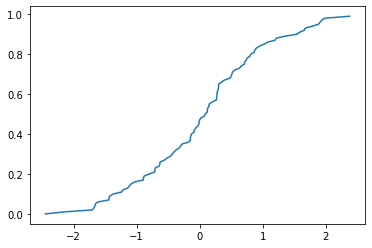

In [14]:
x = np.sort(s)
y = np.arange(len(x))/float(len(x)) # [0, 0.1, ..., 0.98, 0.99] if n = 100
plt.plot(x, y)

In [15]:
def emp_cdf(x, samples):
    """
    maps x to F(x), where F is the emprirical distribution function of the samples.
    
    Parameters
    ---------
    x : scalar
    samples : np.array of shape (n,)
    """
    n = samples.shape[0]
    return np.sum(samples <= x) / n

In [16]:
xgrid = np.linspace(-3, 3, num=200)

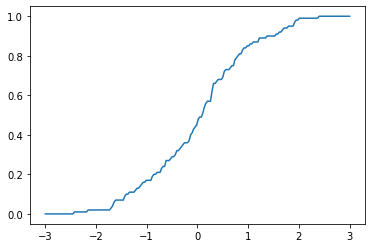

In [17]:
plt.plot(xgrid, vmap(emp_cdf, (0, None))(xgrid, s))

### Empirical cdf, linearly interpolated

Idea from [here](https://stats.stackexchange.com/questions/211175/kullback-leibler-divergence-for-two-samples) and [this paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.422.5121&rep=rep1&type=pdf).

In [18]:
def lin_cdf(x, samples):
    raise NotImplementedError()

### Linearly interpolated empirical pdf

In [19]:
def lin_pdf(samples):
    """Linearized cdf, evaluated at the samples."""
    samples = np.squeeze(samples)
    samples = np.sort(samples)
    n = samples.shape[0]
    
    diffs = np.diff(samples)
    
    return 1 / n / np.concatenate([diffs[0][np.newaxis], diffs])

In [20]:
def kl_divergence(xs, logp):
    """
    Parameters
    --------------
    xs : np.array of shape (n,) or (n,1)
    p : callable, computes log(p(x)) up to an additive constant
    """
    xs = np.squeeze(xs)
    xs = np.sort(xs)
    n = xs.shape[0]
    
    
    return -np.mean(np.log(lin_pdf(xs)) - vmap(logp)(xs))

In [21]:
sample = dist.sample((10000,))
xs = sample

In [22]:
kl_divergence(xs, dist.logpdf)

DeviceArray(-inf, dtype=float32)

In [23]:
lin_pdf(xs)[257]

DeviceArray(0.04004873, dtype=float32)

In [24]:
np.argmin(np.diff(xs.sort()))

DeviceArray(1228, dtype=int32)

In [25]:
xs.sort()[257]

DeviceArray(-1.9550459, dtype=float32)